In [37]:
import cv2
import numpy as np
import pytesseract
import regex as re

In [12]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

from matplotlib import pyplot as plt

In [34]:

pytesseract.pytesseract.tesseract_cmd = r'D:\Program Files (x86)\Tesseract-OCR\tesseract.exe'

In [112]:
def preprocess(gray):
    gaussian = cv2.GaussianBlur(gray, (3, 3), 0, 0, cv2.BORDER_DEFAULT)
    median = cv2.medianBlur(gaussian, 5)
    sobel = cv2.Sobel(median, cv2.CV_8U, 1, 0, ksize = 3)
    ret, binary = cv2.threshold(sobel, 170, 255, cv2.THRESH_BINARY)
    element1 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
    element2 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 7))
    dilation = cv2.dilate(binary, element2, iterations = 1)
    erosion = cv2.erode(dilation, element1, iterations = 1)
    dilation2 = cv2.dilate(erosion, element2,iterations = 3)
    plt.imshow(dilation2)
    plt.show()
    return dilation2


In [122]:
def findPlateNumberRegion(img):
    region = []
    contours,hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for i in range(len(contours)):
        cnt = contours[i]
        area = cv2.contourArea(cnt)

        if (area < 2000):
            continue

        epsilon = 0.001 * cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        rect = cv2.minAreaRect(cnt)
        print ("rect is: ")
        print (rect)

        box = cv2.boxPoints(rect)
        box = np.int0(box)

        height = abs(box[0][1] - box[2][1])
        width = abs(box[0][0] - box[2][0])
        print(height,width)
        ratio =float(width) / float(height)
        print (ratio)
        if (ratio > 7 or ratio < 2.7):
            continue
        region.append(box)
        print ("rect is: ")
        print (rect)
        print (ratio)

    return region

In [123]:
def detect(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    dilation = preprocess(gray)

    region = findPlateNumberRegion(dilation)
    print("region")
    print(region)

    for box in region:
        cv2.drawContours(img, [box], 0, (0, 255, 0), 2)
    ys = [box[0, 1], box[1, 1], box[2, 1], box[3, 1]]
    xs = [box[0, 0], box[1, 0], box[2, 0], box[3, 0]]
    ys_sorted_index = np.argsort(ys)
    xs_sorted_index = np.argsort(xs)

    x1 = box[xs_sorted_index[0], 0]
    x2 = box[xs_sorted_index[3], 0]

    y1 = box[ys_sorted_index[0], 1]
    y2 = box[ys_sorted_index[3], 1]

    img_org2 = img.copy()
    img_plate = img_org2[y1:y2, x1:x2]
    plt.imshow(img_plate)
    plt.show()
    cv2.imwrite('number_plate.jpg', img_plate)
    
    txt = pytesseract.image_to_string(img_plate,config='--psm 7')
    print(txt)
    if (txt != ''):
        txt = ''.join(re.findall(r'(\w+|-)',txt))
        print(txt)

    cv2.namedWindow('img', cv2.WINDOW_NORMAL)
    cv2.imshow('img', img)

    cv2.imwrite('contours.png', img)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

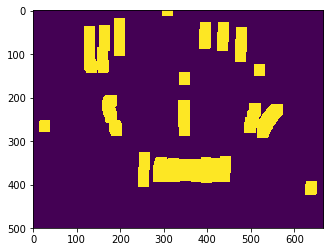

rect is: 
((363.0, 364.5), (178.0, 61.0), -0.0)
61 178
2.918032786885246
rect is: 
((363.0, 364.5), (178.0, 61.0), -0.0)
2.918032786885246
rect is: 
((254.0, 365.0), (26.0, 80.0), -0.0)
80 26
0.325
rect is: 
((526.8280029296875, 253.38540649414062), (80.17366790771484, 87.2270736694336), -87.75425720214844)
84 84
1.0
rect is: 
((346.5, 248.0), (82.0, 27.0), -90.0)
82 27
0.32926829268292684
rect is: 
((180.58348083496094, 241.85504150390625), (38.894447326660156, 98.94953155517578), -9.865806579589844)
104 22
0.21153846153846154
rect is: 
((146.0, 88.5), (60.0, 109.0), -0.0)
109 60
0.5504587155963303
rect is: 
((197.5, 62.0), (25.0, 86.0), -0.0)
86 25
0.29069767441860467
region
[array([[274, 395],
       [274, 334],
       [452, 334],
       [452, 395]], dtype=int64)]


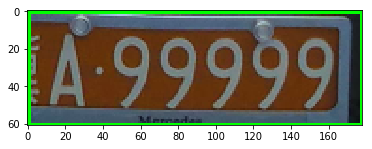

In [124]:
img = cv2.imread('test/3.jpg')
height, width = img.shape[:2]
alpha = 500/height
img = cv2.resize(img, None, fx=alpha, fy=alpha, interpolation=cv2.INTER_AREA)

detect(img)

In [125]:
txt = 'SOMoWH1206'
''.join(re.findall(r'(\w+|-)',txt))

'SOMoWH1206'